In [1]:
from matplotlib import pyplot as plt

%matplotlib ipympl

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 7.5
# 用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['figure.autolayout'] = True
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [2]:
import numpy as np
import pandas as pd
import pylatex
pd.set_option('precision', 2)

from calculate_increases import calculate_increases
from line_chart_with_multiple_lines import line_chart_with_multiple_lines
from grouped_bar_chart import grouped_bar_chart
from parse_data import *

In [3]:
benchmark_max_stack_usages = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('benchmark_max_stack_usages', 'stack_size'),
    'max_stack_usage',
    True
)

benchmark_instruction_counts = parse_profile_data_in_directory_to_dataframe(
    parse_benchmark_instruction_counts_directory('benchmark_instruction_counts'),
    'instruction_count',
    True
)

benchmark_writes_on_hottest_stack_addresses = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('benchmark_writes_on_hottest_stack_addresses', 'writes'),
    'writes_on_hottest_stack_address',
    True
)

max_number_of_stack_frames_on_a_stack_address = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('max_number_of_stack_frames_on_a_stack_address', 'number_of_stack_frames'),
    'max_number_of_stack_frames_on_a_stack_address',
    True
)

writes_on_hottest_address_in_stack_frames = parse_profile_data_in_directory_to_dataframe(
    parse_json_format_profile_data_directory('writes_on_hottest_address_in_stack_frames', 'writes'),
    'writes_on_hottest_address_in_stack_frames',
    True
)

In [4]:
import re

In [5]:
def g(types_of_benchmarks):
    loop_iterations_benchmark_type_pattern = re.compile(r'new_loop2recursion-loop_iterations-(\d+)')
    for benchmark_type in types_of_benchmarks:
        match = loop_iterations_benchmark_type_pattern.match(benchmark_type)
        if match:
            loop_iterations_string, *_ = match.groups()
            loop_iterations = int(loop_iterations_string)
            yield loop_iterations

loop_iterations_list = list(g(benchmark_max_stack_usages['executable_type'].unique()))
loop_iterations_list.sort()
loop_iterations_list

[8, 16, 32, 64]

In [6]:
loop_iterations_executable_type_renaming = { 'new_loop2recursion': f'{0:02}' }

for loop_iterations in loop_iterations_list:
    loop_iterations_executable_type_renaming[f'new_loop2recursion-loop_iterations-{loop_iterations}'] = f'{loop_iterations:02}'

loop_iterations_executable_type_renaming

{'new_loop2recursion': '00',
 'new_loop2recursion-loop_iterations-8': '08',
 'new_loop2recursion-loop_iterations-16': '16',
 'new_loop2recursion-loop_iterations-32': '32',
 'new_loop2recursion-loop_iterations-64': '64'}

In [7]:
loop_iterations_benchmark_max_stack_usages = benchmark_max_stack_usages[
    benchmark_max_stack_usages['executable_type'].isin(
        loop_iterations_executable_type_renaming
    )
].replace(
    to_replace=loop_iterations_executable_type_renaming
).sort_values(
    by=['benchmark', 'executable_type']
)

loop_iterations_benchmark_max_stack_usages

,executable_type,benchmark,max_stack_usage
236,00,average,4.49e+06
231,08,average,1.82e+06
230,16,average,1.22e+06
235,32,average,9.21e+05
226,64,average,7.73e+05
...,...,...,...
201,00,susan,3.81e+05
136,08,susan,3.72e+05
123,16,susan,3.72e+05
188,32,susan,3.72e+05


(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:xlabel='Benchmark', ylabel='Maximum Stack Usage'>)

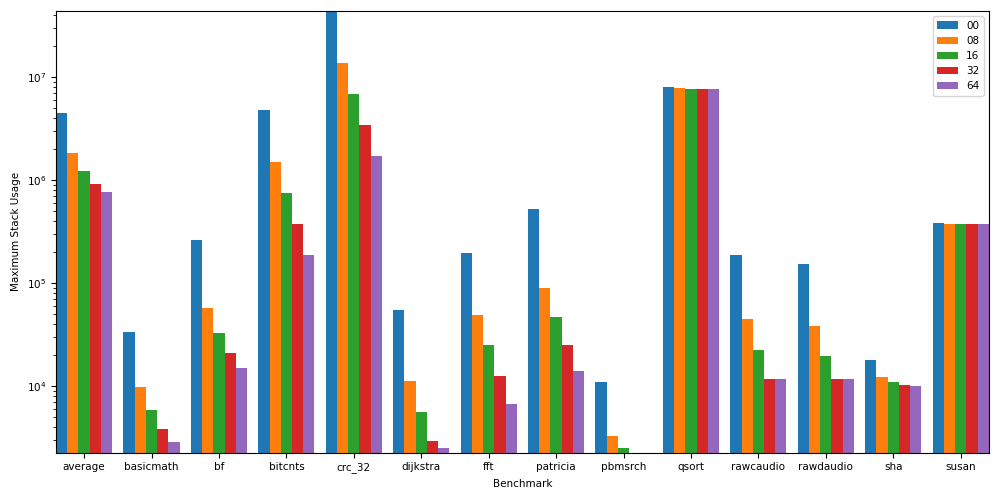

In [8]:
grouped_bar_chart(
    groups=loop_iterations_benchmark_max_stack_usages['benchmark'].unique(),
    labels=loop_iterations_executable_type_renaming.values(),
    data_by_label = (
        loop_iterations_benchmark_max_stack_usages[
            loop_iterations_benchmark_max_stack_usages['executable_type'] == loop_iterations_executable_type
        ]['max_stack_usage']
        for loop_iterations_executable_type in loop_iterations_executable_type_renaming.values()
    ),
    xlabel='Benchmark',
    ylabel='Maximum Stack Usage',
    log=True
)

In [9]:
_[0].savefig('maximum_stack_usages_under_different_loop_iterations.pdf')

In [10]:
maximum_stack_usages_under_different_loop_iterations = calculate_increases(
    loop_iterations_benchmark_max_stack_usages,
    '00',
    [
        f'{loop_iterations:02}' for loop_iterations in loop_iterations_list
    ],
    'max_stack_usage',
    lambda executable_type: f'{executable_type} Change'
).to_latex(
    formatters={
        f'{executable_type} Change': '{:,.2%}'.format
        for executable_type in loop_iterations_executable_type_renaming.values()
    },
    caption='Maximum Stack Usages Under Different Loop Iterations',
    label='table:maximum_stack_usages_under_different_loop_iterations',
    index=False
)

print(maximum_stack_usages_under_different_loop_iterations)

\begin{table}
\centering
\caption{Maximum Stack Usages Under Different Loop Iterations}
\label{table:maximum_stack_usages_under_different_loop_iterations}
\begin{tabular}{lrrrrr}
\toprule
benchmark &       00 & 08 Change & 16 Change & 32 Change & 64 Change \\
\midrule
  average & 4.49e+06 &   -59.51\% &   -72.84\% &   -79.50\% &   -82.81\% \\
basicmath & 3.38e+04 &   -70.93\% &   -82.86\% &   -88.73\% &   -91.48\% \\
       bf & 2.62e+05 &   -78.37\% &   -87.45\% &   -91.99\% &   -94.31\% \\
  bitcnts & 4.80e+06 &   -68.75\% &   -84.37\% &   -92.18\% &   -96.08\% \\
   crc\_32 & 4.38e+07 &   -68.75\% &   -84.37\% &   -92.19\% &   -96.09\% \\
 dijkstra & 5.47e+04 &   -79.72\% &   -89.73\% &   -94.70\% &   -95.41\% \\
      fft & 1.97e+05 &   -74.89\% &   -87.36\% &   -93.60\% &   -96.63\% \\
 patricia & 5.26e+05 &   -82.83\% &   -91.12\% &   -95.26\% &   -97.33\% \\
  pbmsrch & 1.08e+04 &   -70.01\% &   -77.10\% &   -79.17\% &   -79.17\% \\
    qsort & 8.00e+06 &    -2.75\% &    -3.37\%

In [11]:
loop_iterations_benchmark_instruction_counts = benchmark_instruction_counts[
    benchmark_instruction_counts['executable_type'].isin(
        loop_iterations_executable_type_renaming
    )
].replace(
    to_replace=loop_iterations_executable_type_renaming
).sort_values(
    by=['benchmark', 'executable_type']
)

loop_iterations_benchmark_instruction_counts

,executable_type,benchmark,instruction_count
236,00,average,5.90e+07
231,08,average,7.72e+07
230,16,average,7.58e+07
235,32,average,7.52e+07
226,64,average,7.50e+07
...,...,...,...
201,00,susan,6.87e+07
136,08,susan,1.11e+08
123,16,susan,1.08e+08
188,32,susan,1.08e+08


(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:xlabel='Benchmark', ylabel='Instruction Count'>)

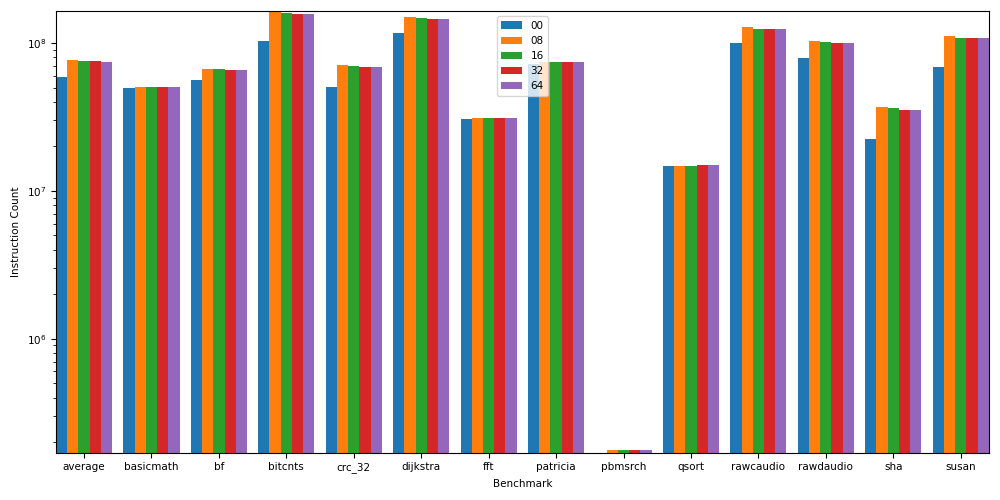

In [12]:
grouped_bar_chart(
    groups=loop_iterations_benchmark_instruction_counts['benchmark'].unique(),
    labels=loop_iterations_executable_type_renaming.values(),
    data_by_label = (
        loop_iterations_benchmark_instruction_counts[
            loop_iterations_benchmark_instruction_counts['executable_type'] == loop_iterations_executable_type
        ]['instruction_count']
        for loop_iterations_executable_type in loop_iterations_executable_type_renaming.values()
    ),
    xlabel='Benchmark',
    ylabel='Instruction Count',
    log=True
)

In [13]:
_[0].savefig('instruction_counts_under_different_loop_iterations.pdf')

In [14]:
instruction_counts_under_different_loop_iterations = calculate_increases(
    loop_iterations_benchmark_instruction_counts,
    '00',
    [
        f'{loop_iterations:02}' for loop_iterations in loop_iterations_list
    ],
    'instruction_count',
    lambda executable_type: f'{executable_type} Change'
).to_latex(
    formatters={
        f'{executable_type} Change': '{:,.2%}'.format
        for executable_type in loop_iterations_executable_type_renaming.values()
    },
    caption='Instruction Counts Under Different Loop Iterations',
    label='table:instruction_counts_under_different_loop_iterations',
    index=False
)

print(instruction_counts_under_different_loop_iterations)

\begin{table}
\centering
\caption{Instruction Counts Under Different Loop Iterations}
\label{table:instruction_counts_under_different_loop_iterations}
\begin{tabular}{lrrrrr}
\toprule
benchmark &       00 & 08 Change & 16 Change & 32 Change & 64 Change \\
\midrule
  average & 5.90e+07 &    30.87\% &    28.56\% &    27.62\% &    27.26\% \\
basicmath & 4.97e+07 &     1.81\% &     1.68\% &     1.63\% &     1.63\% \\
       bf & 5.62e+07 &    19.74\% &    18.49\% &    17.86\% &    17.23\% \\
  bitcnts & 1.04e+08 &    58.61\% &    54.18\% &    51.92\% &    51.77\% \\
   crc\_32 & 5.07e+07 &    40.13\% &    37.60\% &    36.33\% &    35.70\% \\
 dijkstra & 1.17e+08 &    28.08\% &    25.84\% &    24.72\% &    24.06\% \\
      fft & 3.05e+07 &     2.75\% &     2.61\% &     2.55\% &     2.52\% \\
 patricia & 7.24e+07 &     2.38\% &     2.11\% &     2.22\% &     2.22\% \\
  pbmsrch & 1.70e+05 &     4.45\% &     4.39\% &     4.37\% &     4.37\% \\
    qsort & 1.46e+07 &     1.08\% &     0.98\% &  

In [15]:
loop_iterations_benchmark_writes_on_hottest_stack_addresses = benchmark_writes_on_hottest_stack_addresses[
    benchmark_writes_on_hottest_stack_addresses['executable_type'].isin(
        loop_iterations_executable_type_renaming
    )
].replace(
    to_replace=loop_iterations_executable_type_renaming
).sort_values(
    by=['benchmark', 'executable_type']
)

loop_iterations_benchmark_writes_on_hottest_stack_addresses

,executable_type,benchmark,writes_on_hottest_stack_address
236,00,average,1.29e+05
231,08,average,1.64e+05
230,16,average,2.16e+05
235,32,average,3.06e+05
226,64,average,4.51e+05
...,...,...,...
201,00,susan,1.78e+04
136,08,susan,2.17e+05
123,16,susan,4.83e+05
188,32,susan,9.84e+05


(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot:xlabel='Benchmark', ylabel='Writes on Hottest Stack Address'>)

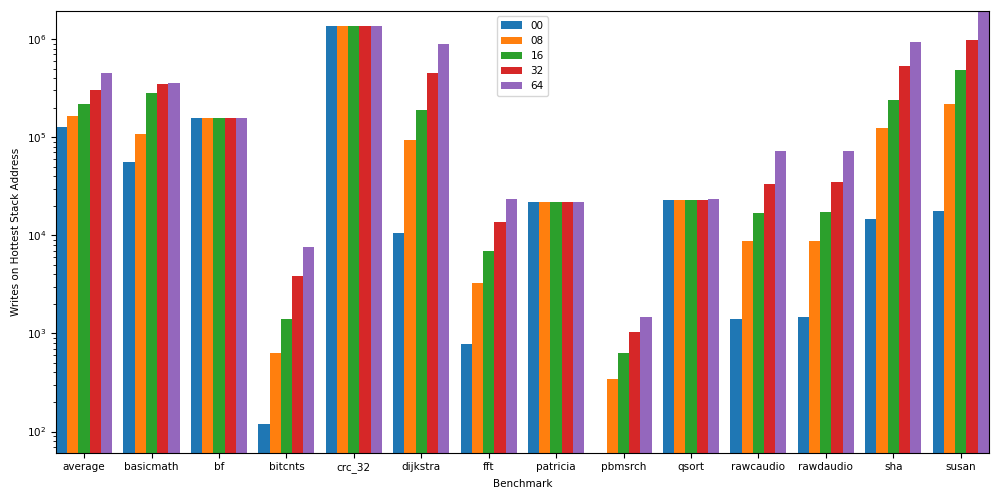

In [16]:
grouped_bar_chart(
    groups=loop_iterations_benchmark_writes_on_hottest_stack_addresses['benchmark'].unique(),
    labels=loop_iterations_executable_type_renaming.values(),
    data_by_label = (
        loop_iterations_benchmark_writes_on_hottest_stack_addresses[
            loop_iterations_benchmark_writes_on_hottest_stack_addresses['executable_type'] == loop_iterations_executable_type
        ]['writes_on_hottest_stack_address']
        for loop_iterations_executable_type in loop_iterations_executable_type_renaming.values()
    ),
    xlabel='Benchmark',
    ylabel='Writes on Hottest Stack Address',
    log=True
)

In [17]:
_[0].savefig('writes_on_hottest_stack_address_under_different_loop_iterations.pdf')

In [18]:
writes_on_hottest_stack_address_under_different_loop_iterations = calculate_increases(
    loop_iterations_benchmark_writes_on_hottest_stack_addresses,
    '00',
    [
        f'{loop_iterations:02}' for loop_iterations in loop_iterations_list
    ],
    'writes_on_hottest_stack_address',
    lambda executable_type: f'{executable_type} Change'
).to_latex(
    formatters={
        f'{executable_type} Change': '{:,.2%}'.format
        for executable_type in loop_iterations_executable_type_renaming.values()
    },
    caption='Writes on Hottest Stack Address Under Different Loop Iterations',
    label='table:writes_on_hottest_stack_address_under_different_loop_iterations',
    index=False
)

print(writes_on_hottest_stack_address_under_different_loop_iterations)

\begin{table}
\centering
\caption{Writes on Hottest Stack Address Under Different Loop Iterations}
\label{table:writes_on_hottest_stack_address_under_different_loop_iterations}
\begin{tabular}{lrrrrr}
\toprule
benchmark &       00 & 08 Change & 16 Change & 32 Change &  64 Change \\
\midrule
  average & 1.29e+05 &    27.68\% &    67.92\% &   137.89\% &    250.47\% \\
basicmath & 5.60e+04 &    94.31\% &   406.32\% &   527.37\% &    531.60\% \\
       bf & 1.56e+05 &     0.00\% &     0.00\% &     0.00\% &      0.00\% \\
  bitcnts & 1.18e+02 &   433.90\% & 1,088.14\% & 3,194.92\% &  6,372.88\% \\
   crc\_32 & 1.37e+06 &     0.00\% &     0.00\% &     0.00\% &      0.00\% \\
 dijkstra & 1.07e+04 &   781.07\% & 1,660.62\% & 4,124.89\% &  8,331.87\% \\
      fft & 7.76e+02 &   317.78\% &   787.11\% & 1,675.52\% &  2,893.17\% \\
 patricia & 2.18e+04 &     0.00\% &     0.00\% &     0.00\% &      0.00\% \\
  pbmsrch & 6.10e+01 &   457.38\% &   929.51\% & 1,595.08\% &  2,290.16\% \\
    qsort & 2.